In [1]:
import numpy as np
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import svm

# Portfolio Project - Attacks on Industrial Control Systems (ICS) - Electrical Pipelines
# Model 1 - Support Vector Machines

In [2]:
# Loading the cleansed dataset, with correct types
column_names = pd.read_csv("CleanData/clean_dataset.csv", nrows=0).columns.tolist()
dtype = {col: 'float64' for col in column_names[:-1]}
dtype[column_names[-1]] = 'object'
dataset = pd.read_csv("CleanData/clean_dataset.csv", dtype=dtype)

# Describe the data to make sure we loaded the cleanset dataset properly
dataset.describe()

,R1-PA1:VH,R1-PM1:V,R1-PA2:VH,R1-PM2:V,R1-PA3:VH,R1-PM3:V,R1-PA4:IH,R1-PM4:I,R1-PA5:IH,R1-PM5:I,...,control_panel_log3,control_panel_log4,relay1_log,relay2_log,relay3_log,relay4_log,snort_log1,snort_log2,snort_log3,snort_log4
count,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,...,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000,78377.000000
mean,-15.802424,130764.039577,2.175196,131035.528095,6.834315,131395.717581,-14.334996,393.949321,3.538540,387.438133,...,0.000026,0.000026,0.035916,0.026436,0.026500,0.035597,0.000051,0.000051,0.000089,0.000077
std,100.876750,8546.118477,111.743169,5393.135370,97.065063,5443.752388,99.601107,190.966011,109.504977,151.277183,...,0.005051,0.005051,0.186082,0.160430,0.160618,0.185285,0.007144,0.007144,0.009450,0.008749
min,-179.988962,0.000000,-179.994691,0.000000,-179.994691,0.000000,-179.994691,0.000000,-179.994691,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,-100.416583,131057.982300,-102.129727,130732.029800,-69.459673,131133.202100,-98.159129,305.793700,-94.790138,311.836330,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,-28.865614,131684.814000,8.118812,131358.861500,13.401483,131760.033900,-23.514188,378.671480,1.885031,383.249230,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,68.096034,132186.279400,104.897113,131885.400200,85.324875,132261.499300,66.274028,456.676340,102.674037,460.338540,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,179.994691,151592.990400,179.994691,151567.917200,179.988962,151693.283500,179.994691,1779.462980,179.994691,1265.656320,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Slit the dataset into Train and Test set

In [3]:
#test_size 0.2 means 20% of the dataset will be sampled, 
# we also use stratify=y to keep the proportions as our dataset is highly imbalanced
train, test = train_test_split(dataset, test_size=0.2, stratify=dataset.marker) 
X_train = train.drop(columns="marker") #drop the marker column
y_train = train.marker #take the marker column
X_test = test.drop(columns="marker")
y_test = test.marker

### Scale the data
As we can observe in the analysis of the data, the data is not normalized and some columns have values above 100.000, while others are narrowed between 0 and 100, with negative values. 
There is a risk of feature dominance and introducing bias in the model.
We therefore need to scale the data.

Scaling options: min-max normalization and standardization.
Min-max is known to be useful for algorithms sensitive to feature scales (e.g., k-nearest neighbors), while standardization cam be used more in case of regression techniques or neural networks. 
We will therefore go with min-max normalization.

In [4]:
# Only standardize the predictors.
from sklearn.preprocessing import MinMaxScaler

scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)

### Cross-Validation
SVM models have multiple hyperparameters, the most two important ones being the Kernel and the Cost Parameter. 
The following kernels will be tested and chosen through cross-validation: Linear, Polynomial, RBF. 
As for the Cost, it controls the trade-off between achieving a low training error and a few training error, to avoid overfitting. We will use random search, and apply it so that the computation cost is reasonnable. We added use of PCA as the performance was still not manageable. We also used univeriate feature selection for performance reasons.

In [6]:
from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_classif

# Univariate Feature Selection
selector = SelectKBest(f_classif, k=50)
reduced_data = selector.fit_transform(X_train, y_train)

# Apply PCA
pca = PCA(n_components=0.90)  # Retain 90% of the variance
X_pca = pca.fit_transform(reduced_data)

# SVM model
svm = SVC()

# Define the parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': [1, 0.1, 0.01],
    'kernel': ['linear', 'rbf']
}

# Grid search
grid_search = GridSearchCV(svm, param_grid, refit=True, verbose=2, cv=5)
# Fit the model
grid_search.fit(X_pca, y_train)

# Best parameters
print("Best parameters found: ", grid_search.best_params_, "\n")
print("Best cross-validation score: ", grid_search.best_score_)

Best parameters found:  {'C': 10, 'gamma': 1, 'kernel': 'rbf'} 

Best cross-validation score:  0.7172294001671327


### Build and Train the model
We can now build and train the SVM model with the hyperparameters found using univariate feature selection, PCA and grid search.

In [8]:
## Build the model - with a poly kernel and cost of 2 as found from our cross-validation.
lin_clf = SVC(kernel='rbf', C=10, gamma=1) # Runs the one-versus-rest approach in multi-class classification
lin_clf.fit(X_train, y_train) 

SVC(C=10, gamma=1)

### Confusion Matrix (Training Set)

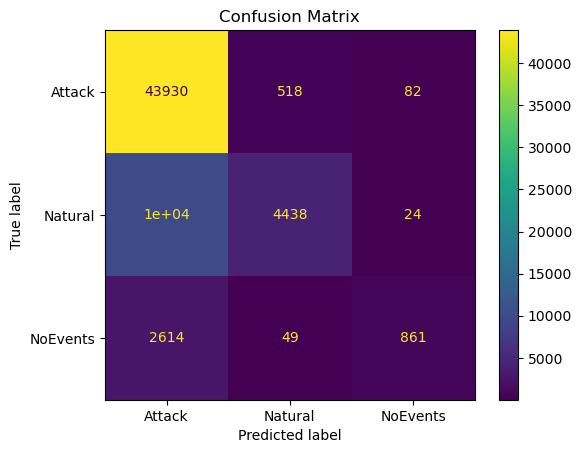

In [11]:
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

cm = metrics.confusion_matrix(y_train, lin_clf.predict(X_train))
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Attack', 'Natural', 'NoEvents'])
cm_display.plot()
plt.title('Confusion Matrix')
plt.show()



## model prediction and performance
#Plot the confusion matrix obtained in the training set and report the accuracy
#Plot the confusion matrix obtained in the test set and report the accuracy.
#Try the radial Kernel in your SVM classification. Keep the other parameters default.
#Visualize the test-set confusion matrix and report the test accuracy of this model.
#Check other optimization methids by using cross-validation, compare SVCs with different Kernels, parameters, as well as one-versus-one approach. 

### Measure Performance (Test Set)

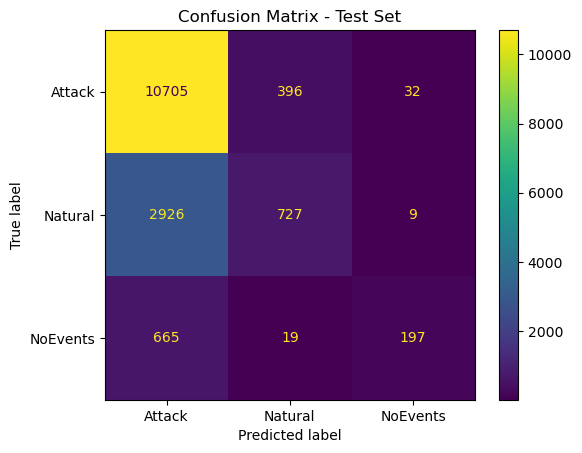

Precision: 0.7377
Recall: 0.4612
F1 Score: 0.4989
Accuracy: 0.74


In [21]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

predict = lin_clf.predict(X_test)
cm = metrics.confusion_matrix(y_test, predict)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Attack', 'Natural', 'NoEvents'])
cm_display.plot()
plt.title('Confusion Matrix - Test Set')
plt.show()

# Compute precision and recall
# Assuming you have true labels (y_true) and predicted labels (y_pred)
precision = precision_score(y_test, predict, average='macro')  # 'macro' for multiclass
recall = recall_score(y_test, predict, average='macro')
f1 = f1_score(y_test, predict, average='macro')
accuracy = accuracy_score(y_test, predict)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Accuracy: {accuracy:.2f}")